# Testing

- Check DP bounds not exceeded (move a point and look for its detection probability)
- Check changing standard deviation/outputs of training data doesn't affect anything
- Check scaling lengthscale and input locations simultaneously doesn't affect anything

In [339]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import dp4gp

Y = np.array([0.0,1.0])
test_inputs = np.array([1.0,3.0])
X = np.array([0.0,2.0])
pseudo_inputs = np.array([0.0,2.0])
lengthscales = 20
sigma = 0.1
calc_normal=True
sens = 1.0
delta = 0.01
eps = 1.0

def get_peroutput_samples(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal,sens,delta,eps,Nsamples):
    test_inputs = np.hstack([test_inputs,X])
    test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)
    scalings = {}
    #normal_peroutput_msense /= 5.0 #np.max(normal_peroutput_msense)
    for i,o in zip(test_inputs,normal_peroutput_msense):
        scalings[i] = o
    new_test_cov, new_normal_msense, new_pseudo_msense, new_normal_peroutput_msense, new_pseudo_peroutput_msense, new_normal_mu, new_pseudo_mu, new_K_normal, new_K_pseudo, new_normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,scale=scalings,calc_normal=True)
    msense = np.max(new_normal_peroutput_msense)
    samps = []
    for it in range(Nsamples):
        samp = dp4gp.draw_sample(new_test_cov, test_inputs, new_normal_mu, msense, sens, delta, eps)
        samps.append(samp)
    return np.array(samps)

def get_normal_samples(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal,sens,delta,eps,Nsamples):
    test_inputs = np.hstack([test_inputs,X])
    test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)
    msense = np.max(normal_peroutput_msense)
    samps = []
    for it in range(Nsamples):
        samp = dp4gp.draw_sample(test_cov, test_inputs, normal_mu, msense, sens, delta, eps)
        samps.append(samp)
    return np.array(samps)
 
fn = get_peroutput_samples #get_normal_samples #
ymean = 1.5
ystd = 1.0
Ytransformed = dp4gp.transform(Y.copy(),ymean,ystd)
sigmatransformed = sigma / ystd
Nsamples = 100000
samples = fn(Ytransformed,test_inputs,X,pseudo_inputs,lengthscales,sigmatransformed,calc_normal,sens,delta,eps,Nsamples)
samples = dp4gp.untransform(samples.copy(),ymean,ystd)

Y[1]+=1.0
Ytransformed = dp4gp.transform(Y.copy(),ymean,ystd)
sigmatransformed = sigma / ystd
samples_prime = fn(Ytransformed,test_inputs,X,pseudo_inputs,lengthscales,sigmatransformed,calc_normal,sens,delta,eps,Nsamples)
samples_prime = dp4gp.untransform(samples_prime.copy(),ymean,ystd)

Calculating covariance between test inputs
Minimum eigen value: 0.000
Maximum K** 1.00
Calculating covariance between training inputs and test inputs
Maximum k* 1.00
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Maximum k* 1.00
Calculating K_NN
Calculating lambda
Calculating covariance between test inputs
Minimum eigen value: 0.000
Maximum K** 0.68
Calculating covariance between training inputs and test inputs
Maximum k* 0.55
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Maximum k* 0.55
Calculating K_NN
Calculating lambda
Calculating covariance between test inputs
Minimum eigen value: 0.000
Maximum K** 1.00
Calculating covariance between training inputs and test inputs
Maximum k* 1.00
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Maximum k* 1.00
Calculating K_NN
Calculating lambda
Calculating covariance between test inputs
Minimum eigen value: 0.000
Maximum K** 0.68
Calculating covaria

In [333]:
np.std(Y)

1.0

In [334]:
np.hstack([test_inputs,X])

array([ 1.,  3.,  0.,  2.])

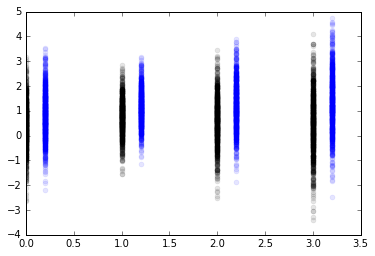

In [306]:
plt.plot(np.hstack([test_inputs,X]),samples.T,'.k',markersize=10,alpha=0.1);
plt.plot(np.hstack([test_inputs,X])+0.2,samples_prime.T,'.b',markersize=10,alpha=0.1);

In [346]:
np.mean(samples,0) - np.mean(samples_prime,0)

array([-0.3843225 , -0.85827385, -0.42161916, -0.60151858])

In the plot you can see that more noise has been added to the locations where the means differ more.

In [341]:
plt.figure(figsize=[12,12])
from scipy.stats import multivariate_normal
stepsize = 0.1
x, y = np.mgrid[-10:10:stepsize, -10:10:stepsize]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv_sample = multivariate_normal(np.mean(samples,0)[1], np.cov(samples.T)[1,1])
#plt.contourf(x, y, rv_sample.pdf(pos))
#plt.axis('equal')
rv_sample_prime = multivariate_normal(np.mean(samples_prime,0)[1], np.cov(samples_prime.T)[1,1])
#plt.contour(x, y, rv_sample_prime.pdf(pos))
#plt.axis('equal')

In [342]:
stepsize = 0.0001
p = rv_sample.pdf(np.arange(-30,30,stepsize))
q = rv_sample_prime.pdf(np.arange(-30,30,stepsize))
threshold = 0.0033
#threshold = 0.0027
inc = (p>threshold) & (q>threshold)
print np.max(p[inc]/q[inc])
print np.sum(p[inc])*stepsize**1
print np.exp(eps)

2.64986651682
0.99049535058
2.71828182846


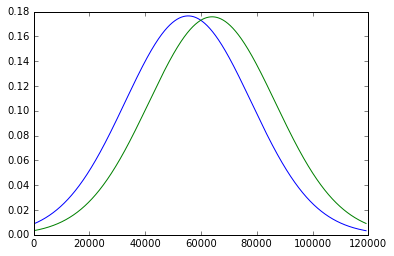

In [343]:
plt.plot(p[inc])
plt.plot(q[inc])

Can we use logic such as:
 - we can have an arbitrary number of test points, so DP should be assured independently for each one.
 - but combining them might help, but we just test the one closest to the training point being adjusted.